# Fussing with the QG outputs

In [9]:
# imports
import os

import xarray

import numpy as np
# import fsspec
import matplotlib
import matplotlib.pyplot as plt
import gsw_xarray as gsw
from xhistogram.xarray import histogram

from dask.diagnostics import ProgressBar

from strucFunct2_ai import timescale

# Load up

In [3]:
qg_file = '/home/xavier/Projects/Oceanography/data/QG/QGModelOutput20years.nc'

qg = xarray.open_dataset(qg_file)

# View

In [4]:
qg

<xarray.Dataset> Size: 23GB
Dimensions:  (time: 7200, lev: 2, y: 256, x: 256, lev_mid: 1, l: 256, k: 129)
Coordinates:
  * time     (time) float64 58kB 0.0 8.64e+04 1.728e+05 ... 6.219e+08 6.22e+08
  * lev      (lev) int64 16B 1 2
  * lev_mid  (lev_mid) float64 8B 1.5
  * x        (x) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * y        (y) float64 2kB 1.953e+03 5.859e+03 ... 9.941e+05 9.98e+05
  * l        (l) float64 2kB 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k        (k) float64 1kB 0.0 6.283e-06 1.257e-05 ... 0.000798 0.0008042
Data variables:
    q        (time, lev, y, x) float64 8GB ...
    u        (time, lev, y, x) float64 8GB ...
    v        (time, lev, y, x) float64 8GB ...
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       622080000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

----

# Manuel Fig 3

In [4]:
#### Loads 15 years time series
chunksSF15 = {'time': 100, 'mid_rbins': 53}

mSF_15 = xarray.open_dataset('/home/xavier/Oceanography/data/QG/SFQG_aver_pos_orien_5yearb.nc', 
                             chunks=chunksSF15)
mSF_15['time'] = mSF_15.time/86400
mSF_15['du1'] = mSF_15.ulls + mSF_15.utts
mSF_15

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 1824, mid_rbins: 59)
Coordinates:
    lev        int64 8B ...
  * time       (time) float64 15kB 5.373e+03 5.374e+03 ... 7.195e+03 7.196e+03
  * mid_rbins  (mid_rbins) float64 472B 2.5e+03 7.5e+03 ... 2.875e+05 2.925e+05
Data variables:
    dr         (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    ulls       (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    utts       (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    du2        (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    du3        (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    du1        (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
Attributes:
    description:  Structure Function Dataset
    Model:        Two-layer QG Turbulence

In [10]:
# Calculates degrees of freedom
nyears = 5
yr2day = 365

# Gets the first 40 index in r
indx = 1
indf = 40

Tmax = yr2day*nyears*86400

qg_tscale3 = timescale(mSF_15.du2.mean(dim='time').values[indx:indf], 
                       mSF_15.dr.mean(dim='time').values[indx:indf])

qg_dof = Tmax/qg_tscale3

nu3 = np.sqrt(qg_dof)

In [11]:
# First-order structure function
from scipy.stats import norm

# First order structure function
sf1_mn = mSF_15.du1.mean(dim='time')[indx:indf]
sf1_std = mSF_15.du1.std(dim='time')[indx:indf]
rr1 = mSF_15.dr.mean(dim='time')[indx:indf].values
du1 = mSF_15.du1.isel(mid_rbins=np.arange(indx, indf)).chunk({'mid_rbins':len(mSF_15.mid_rbins), 'time': 100})


in1 = 2
in2 = 5
in3 = 10
in4 = 18

du1r = 0.4

dull_mn = mSF_15.ulls.mean(dim='time')[indx:indf]
dutt_mn = mSF_15.utts.mean(dim='time')[indx:indf]
dull_std = mSF_15.ulls.std(dim='time')[indx:indf]
dutt_std = mSF_15.utts.std(dim='time')[indx:indf]


# Bins
d1_bins = np.arange(-3, 3.5, du1r)#np.arange(-1e-2, 1e-2, 6e-5)/sf1_std[in1].values
d2_bins = np.arange(-3, 3.5, du1r)#np.arange(-1e-2, 1e-2, 2e-4)/sf1_std[in2].values
d3_bins = np.arange(-3, 3.5, du1r)#np.arange(-1e-2, 1e-2, 6e-4)/sf1_std[in3].values
d4_bins = np.arange(-3, 3.5, du1r)#np.arange(-1e-2, 1e-2, 1e-3)/sf1_std[in4].values


# Histograms
sf1h0 =  histogram(du1.isel(mid_rbins=in1)/sf1_std[in1].values, bins=d1_bins, dim=['time'], density=True)
sf1h2 = histogram(du1.isel(mid_rbins=in2)/sf1_std[in2].values, bins=d2_bins, dim=['time'], density=True)
sf1h10 = histogram(du1.isel(mid_rbins=in3)/sf1_std[in3].values, bins=d3_bins, dim=['time'], density=True)
sf1h15 = histogram(du1.isel(mid_rbins=in4)/sf1_std[in4].values, bins=d4_bins, dim=['time'], density=True)

# Constructs Gaussian
sf1p0 = norm.pdf(d1_bins, sf1_mn[in1]/sf1_std[in1].values, 1)
sf1p2 = norm.pdf(d2_bins, sf1_mn[in2]/sf1_std[in2].values, 1)
sf1p10 = norm.pdf(d3_bins, sf1_mn[in3]/sf1_std[in3].values, 1)
sf1p15 = norm.pdf(d4_bins, sf1_mn[in4]/sf1_std[in4].values, 1)


# Calculates kurtosis
from scipy.stats import skew, kurtosis
sf1_skew = np.zeros((len(rr1),))
sf1_kurt = sf1_skew*0.

for ii in range(len(rr1)):
    
    sf1_skew[ii] = skew(du1.isel(mid_rbins=ii).values, axis=0, bias=True)
    sf1_kurt[ii] = kurtosis(du1.isel(mid_rbins=ii).values, axis=0, fisher=True, bias=True)
#     sf1_kurt[ii] = skew(sf1.D1s.isel(rbins=ii).values)

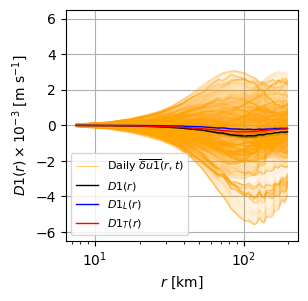

In [13]:
# Plots histograms SF1
colors = plt.cm.jet(np.linspace(0, 1, 4))

fog1 = plt.figure(figsize=(3, 3))

aC = plt.subplot(1, 1, 1)
aC.semilogx(rr1*1e-3, du1.T*1e3, '-', color='orange', 
            linewidth=0.5, alpha=0.1)
aC.semilogx(0, 0, '-', color='orange', linewidth=0.5, alpha=0.8, label='Daily $\\overline{\\delta u1}(r, t)$')
aC.semilogx(rr1*1e-3, sf1_mn*1e3, 'k', linewidth=1, label='$D1(r)$')
aC.fill_between(rr1*1e-3, (sf1_mn + sf1_std/nu3)*1e3, (sf1_mn - sf1_std/nu3)*1e3, 
               alpha=1, color='black', edgecolor=None)
aC.semilogx(rr1*1e-3, dull_mn*1e3, 'b', linewidth=1, label='$D1_L(r)$')
aC.fill_between(rr1*1e-3, (dull_mn + dull_std/nu3)*1e3, (dull_mn - dull_std/nu3)*1e3, 
               alpha=1, color='blue', edgecolor=None)
aC.semilogx(rr1*1e-3, dutt_mn*1e3, 'r', linewidth=1, label='$D1_T(r)$')
aC.fill_between(rr1*1e-3, (dutt_mn + dutt_std/nu3)*1e3, (dutt_mn - dutt_std/nu3)*1e3, 
               alpha=1, color='red', edgecolor=None)
aC.legend(fontsize=8, loc=3)
aC.set_yticks(np.arange(-10, 12, 2))
aC.set_ylim(-6.5, 6.5)
aC.set_xlabel('$r$ [km]')
aC.set_ylabel('$D1(r) \\times 10^{-3}$ [m s$^{-1}$]')
# aC.set_xticklabels([])
aC.grid()
plt.savefig('fig_qg_D1_du1_N.png', bbox_inches = 'tight', format='png', dpi=500)